In [1]:
import cv2 as cv
import numpy as np
import statistics
import joblib
import os
import sklearn
import zipfile
import matplotlib.pyplot as plt
from shutil import copyfile
from tensorflow import keras
from tensorflow.keras.preprocessing import image as kimage
from tensorflow.keras.applications import mobilenet_v2
from sklearn.neighbors import KDTree
detector = cv.CascadeClassifier('haarcascade_frontalface_default.xml')

In [ ]:
!unzip '/content/drive/MyDrive/my-data/thumbnails_features_deduped_publish.zip' -d '/content/' &> /dev/null

Cella per importare VGGFace da github

In [ ]:
!pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install keras_applications --no-deps
filename = "/usr/local/lib/python3.7/dist-packages/keras_vggface/models.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))
import tensorflow as tf

from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input


# Valutazione Modelli

I modelli selezionati sono MobileNet pre-allenato su imagenet, VGG16 pre-allenato su VGGFace e ResNet50 anch'esso allenato preventivamente su VGGFace

In [ ]:
vggface_vgg16 = VGGFace(model='vgg16', include_top=False, input_shape=(224, 224, 3), pooling='avg')

In [ ]:
net = keras.applications.MobileNetV2(input_shape=(224,224,3), weights = 'imagenet', include_top=False, pooling = 'max')

In [ ]:
vggface_resnet = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')

La prima tra le due funzioni seguenti è necessaria ad estrarre le feature dalle immagini dopo aver estratto il volto.  
La seconda invece ricerca e carica le immagini del database alle quali viene applicata la funzione precedente.

In [ ]:
def neural_features_(img, model, prep=None):
    global roi_color 
    x = np.asarray(img)
    detector = cv.CascadeClassifier(cv.data.haarcascades +'haarcascade_frontalface_default.xml')
    results = detector.detectMultiScale(x)
    for (x, y, w, h) in results:
      cv.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
      roi_color = img[y:y + h, x:x + w]
    x = cv.resize(roi_color, (224,224))
    x = x[:,:,-1::-1].astype('float64')
    if prep == 'vggface_resnet':
      x = preprocess_input(x, version = 2) 
      x = np.expand_dims(x, axis=0)
      f = model.predict(x)
    elif prep == 'vggface_vgg16':
      x = preprocess_input(x, version = 1)
      x = np.expand_dims(x, axis=0)
      f = model.predict(x)
    else:
      x = mobilenet_v2.preprocess_input(x)
      x = np.expand_dims(x, axis=0)
      f = model.predict(x)     
    return f.flatten()



def load_data(feature_extractor, directory, num_images_per_person, model, prep='None', limit = 128):
  # num_images_per_person: indica il numero di immagini da estrarre per cartella
  # limit: indica il numero minimo di immagini che deve avere una cartella per
  # essere selezionata
  paths = []
  features = []
  for subdir in os.listdir(directory):
    if len(os.listdir(directory + subdir))>limit:
      cur_path = directory + subdir
      count=0
      for filename in os.listdir(cur_path):
       if count<num_images_per_person:
         if filename.endswith('.jpg'):
            new_path = cur_path + "/"+ filename
            paths.append(new_path)
            image = cv.imread(new_path)
            cur_features = feature_extractor(image, model, prep)
            features.append(cur_features)
         else:
            count = count - 1 # count-1 per evitare di conteggiare i file non .jpg
       else: 
          break
       count=count+1   
    else:
      pass
  features = np.array(features)
  return paths, features

## Creazione Test Set

Estrazione dei percorsi alle immagini e delle feature relative per i tre modelli selezionando solo circa 400 classi per un totale di 6000 immagini circa.

In [ ]:
paths_vgg16, features_vgg16 = load_data(feature_extractor=neural_features_, directory='/content/thumbnails_features_deduped_publish/', 
                              num_images_per_person=15, model = vggface_vgg16, prep = 'vggface_vgg16')

In [ ]:
paths, features = load_data(feature_extractor=neural_features_, directory='/content/thumbnails_features_deduped_publish/', num_images_per_person=15, model = net)

In [ ]:
paths_res, features_res = load_data(feature_extractor=neural_features_, directory='/content/thumbnails_features_deduped_publish/',
                                    num_images_per_person=15, model = vggface_resnet, prep = 'vggface_resnet')

Salvataggio paths e features per utilizzo futuro

In [ ]:
paths, features = joblib.load('/content/drive/MyDrive/my-data/mobilenet_pf.joblib')
paths_vgg16, features_vgg16 = joblib.load('/content/drive/MyDrive/my-data/vgg16_pf.joblib')
paths_res, features_res = joblib.load('/content/drive/MyDrive/my-data/resnet_pf.joblib')

In [ ]:
#joblib.dump((paths, features), '/content/drive/MyDrive/my-data/mobilenet_pf.joblib')

In [ ]:
#joblib.dump((paths_res, features_res), '/content/drive/MyDrive/my-data/resnet_pf.joblib')

In [ ]:
#joblib.dump((paths_vgg16, features_vgg16), '/content/drive/MyDrive/my-data/vgg16_pf.joblib')

Creazione degli alberi per ogni modello

In [ ]:
tree_vgg16 = KDTree(features_vgg16)
tree = KDTree(features)
tree_resnet = KDTree(features_res)

## Confronto grafico

Data l'immagine di query rappresentata (Kate Hudson) si utilizzano i tre modelli per trovare i volti più simili ad essa considerando le altre immagini dell'attrice come ground truth.  


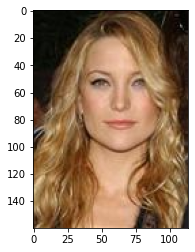

(<matplotlib.image.AxesImage at 0x7f8f0f01ff10>, None)

In [ ]:
query_image = cv.imread(paths[92])
plt.imshow(query_image[:,:,::-1]), plt.show()

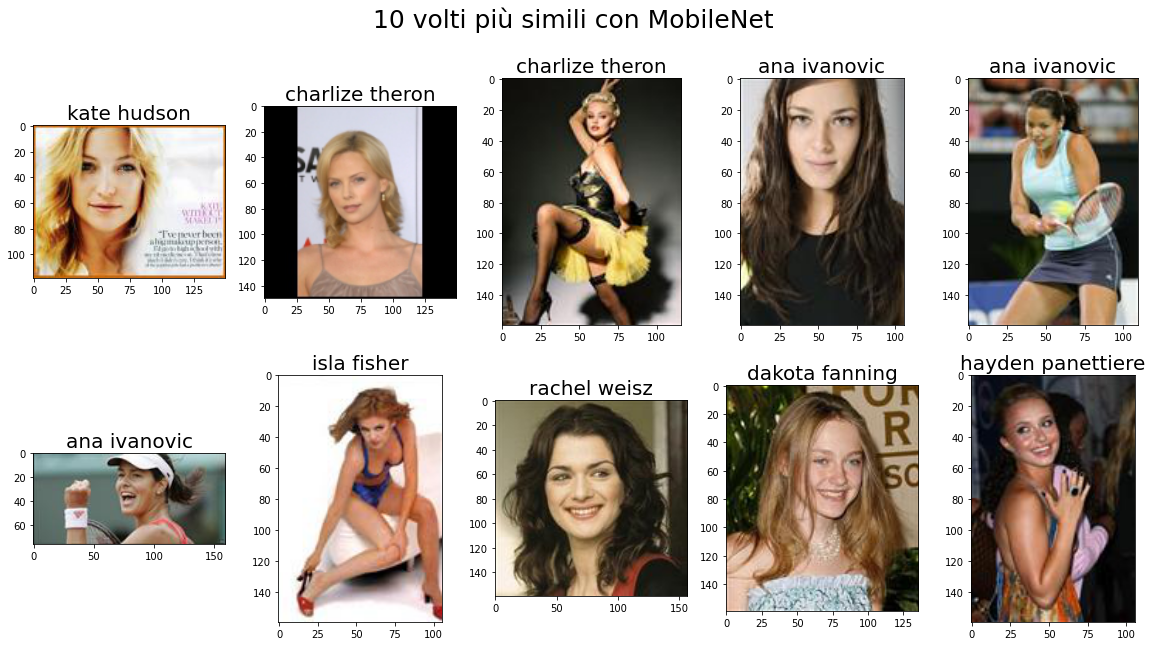

In [ ]:
query_path = paths[92]
prova = [x for x in paths if x != query_path]
query_features=features[92]
query_features = np.expand_dims(query_features, axis=0)
dist, ind = tree.query(query_features, k=10, dualtree=True)
fig = plt.figure(figsize=(20,10))
for i in range(10):
    sub = fig.add_subplot(2,5,i+1)
    sub.title.set_text(prova[ind[0][i]].split('/')[3])
    sub.title.set_size(20)
    #sub.text(10, -20, ("distance:" + str(round(dist[0][i],3))), fontsize=15)
    fig.suptitle('10 volti più simili con MobileNet',size=25)
    sub.imshow(kimage.load_img(prova[ind[0][i]]), interpolation='bilinear')

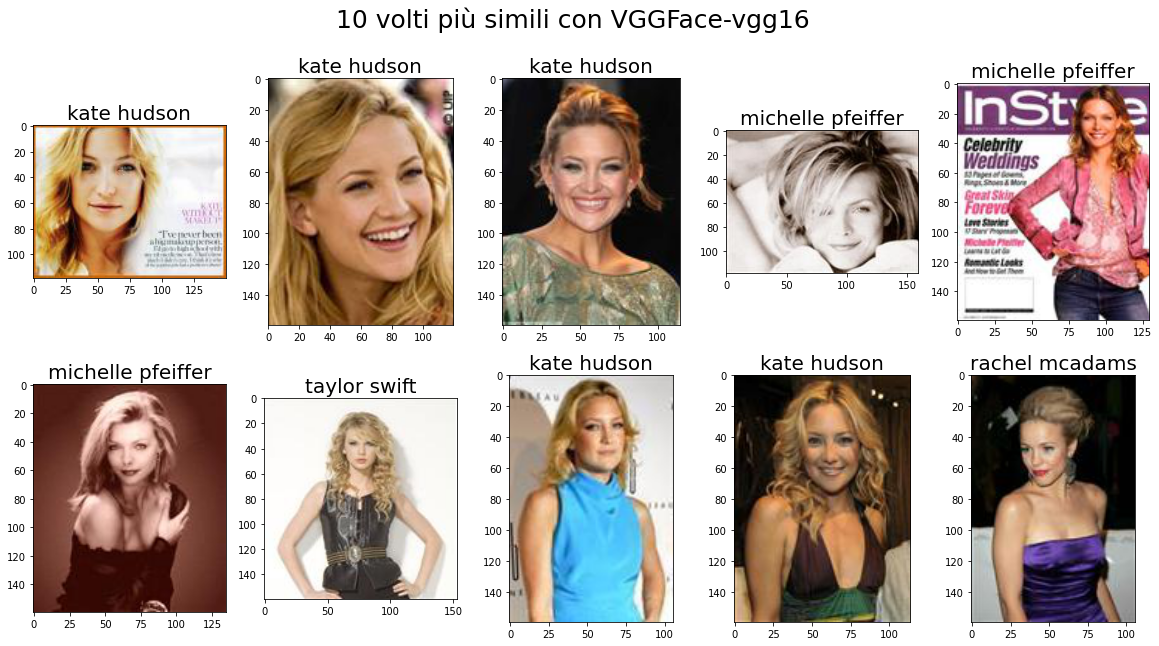

In [ ]:
query_path = paths_vgg16[92]
prova = [x for x in paths_vgg16 if x != query_path]
query_features=features_vgg16[92]
query_features = np.expand_dims(query_features, axis=0)
dist, ind = tree_vgg16.query(query_features, k=10, dualtree=True)
fig = plt.figure(figsize=(20,10))
for i in range(10):
    sub = fig.add_subplot(2,5,i+1)
    sub.title.set_text(prova[ind[0][i]].split('/')[3])
    sub.title.set_size(20)
    #sub.text(10, -20, ("distance:" + str(round(dist[0][i],3))), fontsize=15)
    fig.suptitle('10 volti più simili con VGGFace-vgg16',size=25)
    sub.imshow(kimage.load_img(prova[ind[0][i]]), interpolation='bilinear')

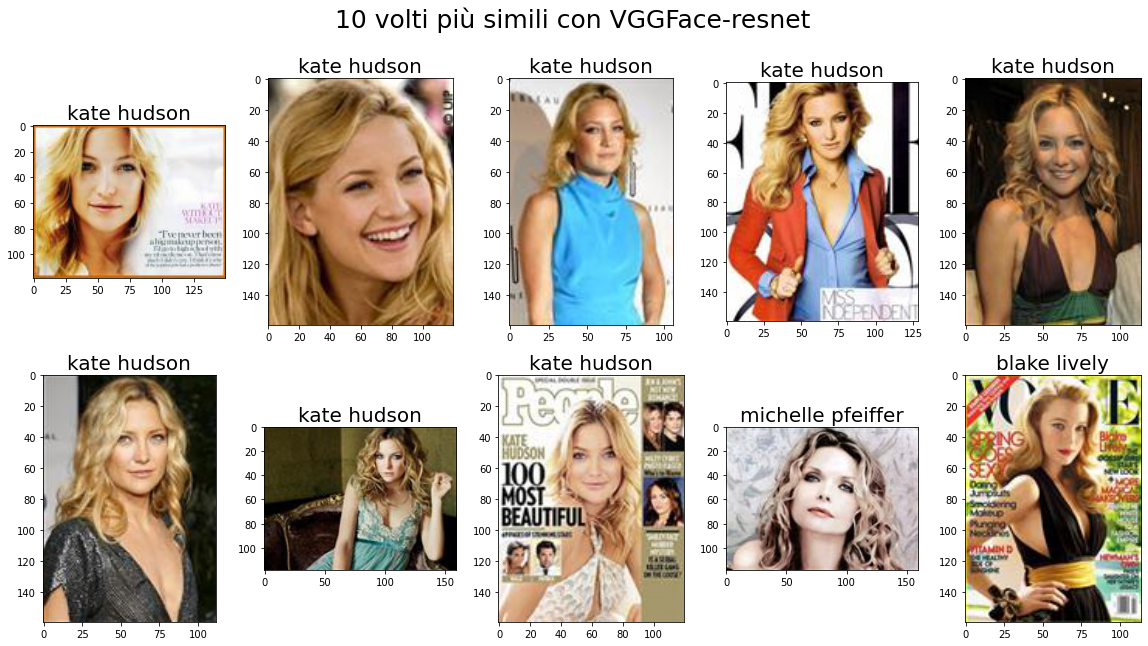

In [ ]:
query_path = paths_res[92]
prova = [x for x in paths_res if x != query_path]
query_features=features_res[92]
query_features = np.expand_dims(query_features, axis=0)
dist, ind = tree_resnet.query(query_features, k=10, dualtree=True)
fig = plt.figure(figsize=(20,10))
for i in range(10):
    sub = fig.add_subplot(2,5,i+1)
    sub.title.set_text(prova[ind[0][i]].split('/')[3])
    sub.title.set_size(20)
    #sub.text(10, -20, ("distance:" + str(round(dist[0][i],3))), fontsize=15)
    fig.suptitle('10 volti più simili con VGGFace-resnet',size=25)
    sub.imshow(kimage.load_img(prova[ind[0][i]]), interpolation='bilinear')

# Calcolo misure quantitative per selezione del modello

Funzione per calcolare recall, precision e f1score per ogni immagine tra quelle nel test per poi farne la media.
Più precisamente, ogni immagine tra le 6015 viene rimossa momentaneamente dal test per essere usata come query. Per questa vengono calcolate le metriche sopra citate e poste in una lista. L'operazione viene ripetuta per ogni immagine in modo da calcolare la media per ogni metrica.  
Il calcolo della precision è personalizzato al  task richiesto dunque il denominatore sarà fissato a 10. Per questa ragione e per il fatto che in molte classi sono presenti del falsi positivi o immagini poco chiare le metriche utilizzate non sono da considerarsi in senso assoluto (non descrivono la capacità del modello). Lo scopo della creazione è unicamente il confronto tra i tre modelli. 

In [ ]:
def prec_rec_f1(num_images, paths, albero, features):
  black_list = [y for y in range(num_images)]
  rec = []
  prec = []
  f1 = []
  for j in black_list:
    num = 0
    query_path = paths[j]
    prova = [x for x in paths if x != query_path]
    query_features = features[j]
    query_features = np.expand_dims(query_features, axis=0)
    dist, ind = albero.query(query_features, k=10, dualtree=True)
    for i in range (10):
      if ind[0][i] < j:
        if query_path.split('/')[3] == prova[ind[0][i]].split('/')[3]:
           num = num + 1
        else:
          pass
      else:
        if query_path.split('/')[3] == prova[ind[0][i]-1].split('/')[3]:
           num = num + 1
        else:
          pass       
    recall = num / 14
    precision = num / 10
    f1score = 2 * (precision * recall) / (precision + recall + 0.00000000001)
    rec.append(recall)
    prec.append(precision)
    f1.append(f1score)
  print('Recall: {}'.format(statistics.mean(rec)))
  print('Precision: {}'.format(statistics.mean(prec)))
  print('F1score: {}'.format(statistics.mean(f1))) 
  #return statistics.mean(rec), statistics.mean(prec), statistics.mean(f1)

In [ ]:
print('Risultati per MobileNet')
print('***********************')
prec_rec_f1(6015, paths, features = features, albero = tree)

Risultati per MobileNet
***********************
Recall: 0.09181807386296163
Precision: 0.1285453034081463
F1score. 0.10712108616884547


In [ ]:
print('Risultati per VGGFace-vgg16')
print('***************************')
prec_rec_f1(6015, paths_vgg16, features = features_vgg16, albero = tree_vgg16)

Risultati per VGGFace-vgg16
***************************
Recall: 0.21017693860586628
Precision: 0.2942477140482128
F1score. 0.24520642836877804


In [ ]:
print('Risultati per VGGFace-resnet')
print('****************************')
prec_rec_f1(6015, paths_res, features = features_res, albero = tree_resnet)

Risultati per VGGFace-resnet
****************************
Recall: 0.37445671535447095
Precision: 0.5242394014962594
F1score. 0.43686616790877236


# Radius

Sono stati fatti alcuni tentativi impostando il raggio entro il quale selezionare le immagini più simili.

In [ ]:
def prec_rec_f1_radius(num_images, paths, albero, features, raggio = 85):
  black_list = [y for y in range(num_images)]
  rec = []
  prec = []
  f1 = []
  for j in black_list:
    num = 0
    query_path = paths[j]
    prova = [x for x in paths if x != query_path]
    query_features = features[j]
    query_features = np.expand_dims(query_features, axis=0)
    ind, dist = albero.query_radius(query_features, r = raggio, return_distance=True, sort_results=True)
    den = albero.query_radius(query_features, r = raggio, count_only=True)
    for i in range (den[0]):
      if ind[0][i] < j:
        if query_path.split('/')[3] == prova[ind[0][i]].split('/')[3]:
           num = num + 1
        else:
           pass
      else: 
         if query_path.split('/')[3] == prova[ind[0][i]-1].split('/')[3]:
           num = num + 1
         else:
            pass       
    recall = num / 14
    precision = num / den[0]
    f1score = 2 * (precision * recall) / (precision + recall + 0.00000000001)
    rec.append(recall)
    prec.append(precision)
    f1.append(f1score)
  print('Recall: {}'.format(statistics.mean(rec)))
  print('Precision: {}'.format(statistics.mean(prec)))
  print('F1score. {}'.format(statistics.mean(f1))) 
  print('Con un raggio pari a {}'.format(raggio))   
  #return statistics.mean(rec), statistics.mean(prec), statistics.mean(f1)

In [ ]:
print('Risultati per MobileNet')
print('****************************')
prec_rec_f1_radius(num_images = 6015, paths = paths, albero = tree, features = features, raggio = 78)

Risultati per MobileNet
****************************
Recall: 0.3927324545778411
Precision: 0.05931756515817833
F1score. 0.024150422275027048
Con un raggio pari a 78


In [ ]:
print('Risultati per VGGFace-vgg16')
print('****************************')
prec_rec_f1_radius(num_images = 6015, paths = paths_vgg16, albero = tree_vgg16, features = features_vgg16, raggio = 82)

Risultati per VGGFace-vgg16
****************************
Recall: 0.354803467521672
Precision: 0.29442923968665036
F1score. 0.13540206886929185
Con un raggio pari a 82


In [ ]:
print('Risultati per VGGFace-resnet')
print('****************************')
prec_rec_f1_radius(num_images = 6015, paths = paths_res, albero = tree_resnet, features = features_res, raggio = 82)

Risultati per VGGFace-resnet
****************************
Recall: 0.12977081106756916
Precision: 0.8905717644054995
F1score. 0.2057851502121076
Con un raggio pari a 82


# Retrieval finale con VGGFace-ResNet50

Il modello più performante è ResNet50 dunque i volti verranno ricercati usando le feature estratte con questo metodo.  
Il dato finale considera 15 immagini per classe quindi i volti saranno ricercati in un pool di circa 24000 immagini. 

In [ ]:
def neural_features(img):
    x = cv.resize(img, (224,224))
    x = x[:,:,-1::-1].astype('float64')
    x = preprocess_input(x, version = 2) 
    x = np.expand_dims(x, axis=0)
    f = vggface_resnet.predict(x)   
    return f.flatten()

In [ ]:
paths, features = load_data(feature_extractor=neural_features_, directory='/content/thumbnails_features_deduped_publish/', num_images_per_person=15,
                            model = vggface_resnet, prep = 'vggface_resnet', limit = 0)

In [ ]:
len(features)

In [ ]:
#joblib.dump((paths, features), '/content/drive/MyDrive/my-data/modello_definitivo.joblib')
paths, features = joblib.load('/content/drive/MyDrive/my-data/modello_definitivo.joblib')

In [ ]:
tree = KDTree(features)

In [ ]:
joblib.dump(tree, '/content/drive/MyDrive/my-data/tree_definitivo.joblib')

### Davide

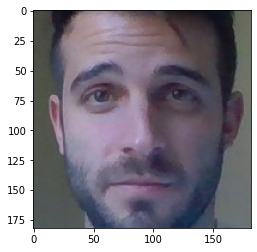

(<matplotlib.image.AxesImage at 0x7fc4790d4910>, None)

In [ ]:
davide = cv.imread('/content/drive/MyDrive/my-data/image001.jpg')
plt.imshow(davide[:,:,::-1]), plt.show()

In [ ]:
query_features = neural_features_(davide, model = vggface_resnet, prep = 'vggface_resnet')
query_features = np.expand_dims(query_features, axis=0)
dist, ind = tree.query(query_features, k=10, dualtree=True)

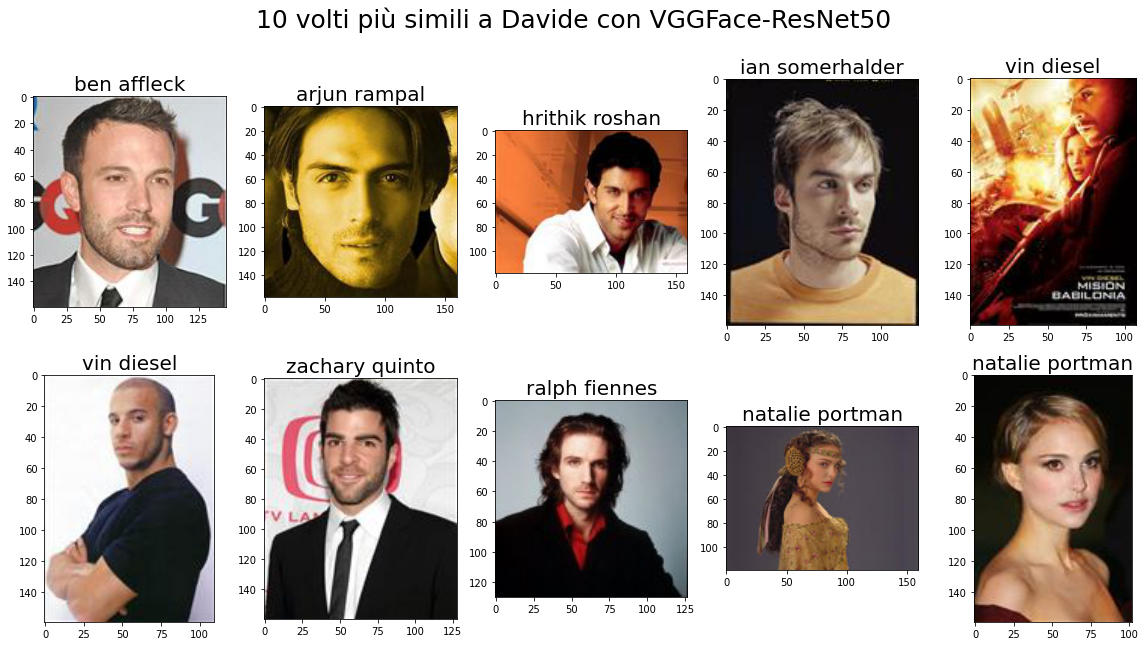

In [ ]:
fig = plt.figure(figsize=(20,10))
for i in range(10):
    sub = fig.add_subplot(2,5,i+1)
    sub.title.set_text(paths[ind[0][i]].split('/')[3])
    sub.title.set_size(20)
    #sub.text(10, -20, ("distance:" + str(round(dist[0][i],3))), fontsize=15)
    fig.suptitle('10 volti più simili a Davide con VGGFace-ResNet50',size=25)
    sub.imshow(kimage.load_img(paths[ind[0][i]]), interpolation='bilinear')

### Alberto

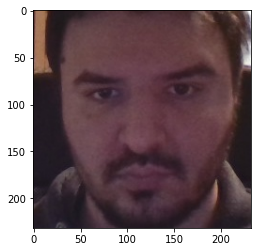

(<matplotlib.image.AxesImage at 0x7fc47c682d50>, None)

In [ ]:
alberto = cv.imread('/content/drive/MyDrive/my-data/Copia di image037.jpg')
plt.imshow(alberto[:,:,::-1]), plt.show()

In [ ]:
query_features = neural_features_(alberto, model = vggface_resnet, prep = 'vggface_resnet')
query_features = np.expand_dims(query_features, axis=0)
dist, ind = tree.query(query_features, k=10, dualtree=True)

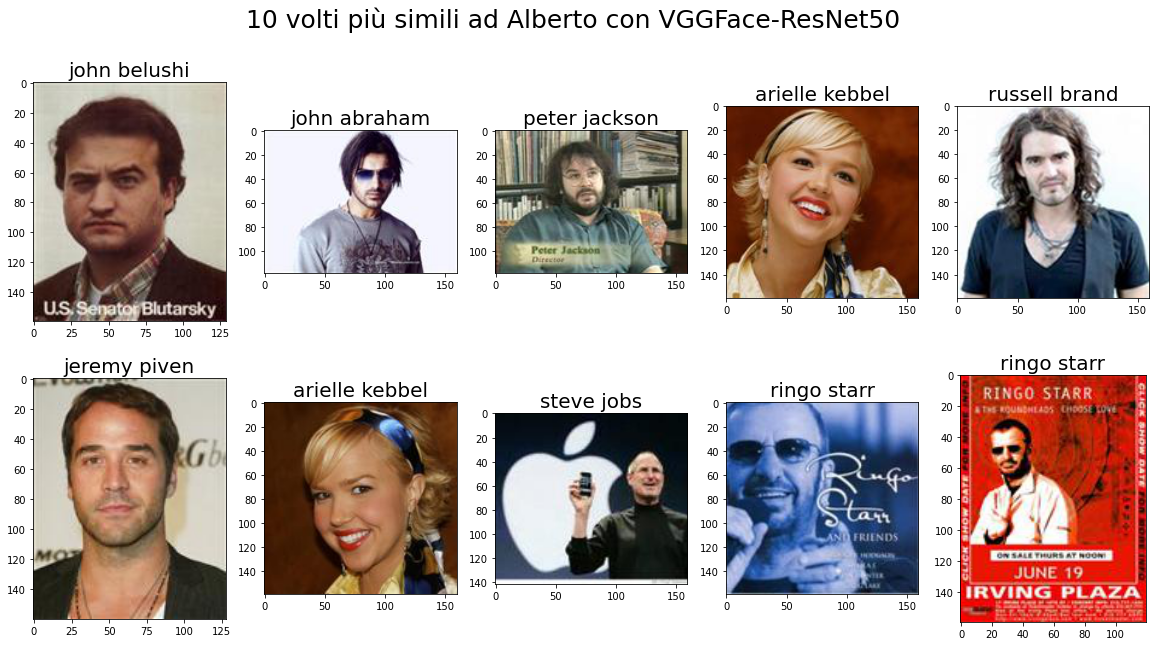

In [ ]:
fig = plt.figure(figsize=(20,10))
for i in range(10):
    sub = fig.add_subplot(2,5,i+1)
    sub.title.set_text(paths[ind[0][i]].split('/')[3])
    sub.title.set_size(20)
    fig.suptitle('10 volti più simili ad Alberto con VGGFace-ResNet50',size=25)
    sub.imshow(kimage.load_img(paths[ind[0][i]]), interpolation='bilinear')

### Alice

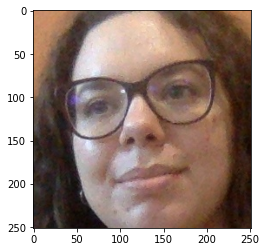

(<matplotlib.image.AxesImage at 0x7fc4efcb1290>, None)

In [ ]:
alice = cv.imread('/content/drive/MyDrive/my-data/Alice1019.jpeg')
plt.imshow(alice[:,:,::-1]), plt.show()

In [ ]:
query_features = neural_features_(alice, model = vggface_resnet, prep = 'vggface_resnet')
query_features = np.expand_dims(query_features, axis=0)
dist, ind = tree.query(query_features, k=10, dualtree=True)

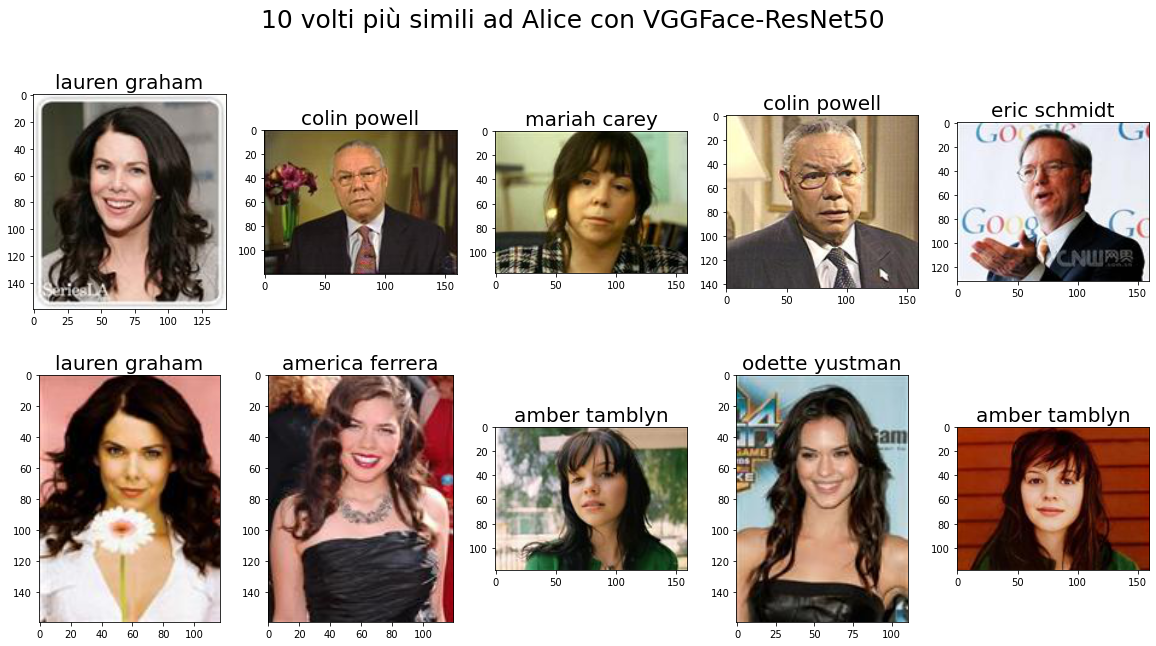

In [ ]:
fig = plt.figure(figsize=(20,10))
for i in range(10):
    sub = fig.add_subplot(2,5,i+1)
    sub.title.set_text(paths[ind[0][i]].split('/')[3])
    sub.title.set_size(20)
    fig.suptitle('10 volti più simili ad Alice con VGGFace-ResNet50',size=25)
    sub.imshow(kimage.load_img(paths[ind[0][i]]), interpolation='bilinear')